In [3]:
#커맨드라인에서 conda install numba 입력
#!conda install numba -y

Fetching package metadata .........
Solving package specifications: .

Package plan for installation in environment /opt/conda:

The following packages will be UPDATED:

    conda: 4.3.21-py36_0 --> 4.3.22-py36_0

conda-4.3.22-p 100% |################################| Time: 0:00:03 137.81 kB/s


In [5]:
"""
파이썬 반복문은 느리다.
다행스럽게도 Numba는 JIT(just in time) 컴파일러를 제공한다.
이 컴파일은 LLVM 컴파일 구조 덕분에 파이썬 코드를 기계코드로 바로 컴파일 한다.
"""
import math
import random
import numpy as np
from numba import jit, vectorize, float64
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

In [6]:
"""
램덤워크
점프하는 랜덤워크를 시뮬레이션해보자.
분자는 실수 직선에 이쏙 0에서 시작한다.
매 단위시간에 분자는 오른쪽이나 왼쪽으로 이동한다.
분자가 경계점을 넘으면 최초 위치로 되돌아온다.

신경과학에서 이러한 확률적모델을 사용한다.
경계점이 없다면 이 모델을 '브라운 운동'이라 한다.
(브라운 운동을 NumPy의 np.cumsum()로 효과적으로 시뮬레이션할 수 있다.)
"""
#다음 랜덤워크 함수는 -1이나 1을 무작위로 반환한다.
def step():
    return 1. if random.random() > .5 else -1.

In [7]:
# n : 총 단계(step)횟수
# 매 단계에서 함수는 새로운 위치로 이동하기 위해 이전 위치에 무작위 단계(step)을 더한다.
# if 문으로 경계점과 점프를 구현한다.
def walk(n):
    x = np.zeros(n)
    dx = 1. / n
    for i in range(n - 1):
        x_new = x[i] + dx * step()
        if x_new > 5e-3:
            x[i+1] = 0.
        else : 
            x[i+1] = x_new
    return x       

In [8]:
n = 100000
x = walk(n)

/opt/conda/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


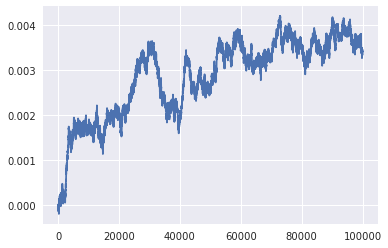

In [10]:
plt.plot(x) #궤적에 대한 그림

In [17]:
%%timeit #성능평가
walk(n)

10 loops, best of 3: 58.1 ms per loop


In [18]:
#numba로 walk, step 함수를 jit컴파일
@jit(nopython=True)
def step_numba():
    return 1. if random.random() > .5 else -1.

In [19]:
@jit(nopython=True)
def walk_numba(n):
    x = np.zeros(n)
    dx = 1. / n
    for i in range(n - 1):
        x_new = x[i] + dx * step_numba()
        if x_new > 5e-3:
            x[i+1] = 0.
        else : 
            x[i+1] = x_new
    return x       

In [21]:
%%timeit
walk_numba(n)
"""
함수를 많이 호출한다면 numba가 효과적.
(nopython=True 는 반드시 필요하지는 않다.
numba는 파이썬 모드와 노파이썬 모드 2가지로 컴파일 할 수있다.
- 파이썬모드: CPython 인터프리터로 컴파일, 리스트와 딕셔너리 사용O, Numpy배열O, 더느림
- 노파이썬모드: CPython 인터프리터로 컴파일X, 리스트와 딕셔너리 사용X, Numpy배열O, 더빠름
"""

100 loops, best of 3: 3.8 ms per loop


In [27]:
#일반함수
"""
numba는 @vectorize 데코레이터를 붙여 Numpy 일반함수(ufuncs)를 만들 수 있도록 한다.
이 속성은 수학 스칼라 연산을 구현한 파이썬 함수를, 원소단위를 기본으로 하는 numpy배열에서 작동하는 벡터화 함수로 변환해준다.
"""
x = np.random.rand(10000000)
%timeit np.cos(2*x**2 + 3*x + 4*np.exp(x**3))

1 loop, best of 3: 1.67 s per loop


In [28]:
@vectorize
def kernel(x):
    return  np.cos(2*x**2 + 3*x + 4*np.exp(x**3))

In [29]:
kernel(1.)

-0.98639139715432589

In [30]:
%timeit kernel(x)

1 loop, best of 3: 736 ms per loop
